# GNN Follow-up Experiments

Five targeted experiments extending **Method C** (GNN + DRE-C, β=0.15, α=0.10).

| Exp | Description | Key variable |
|-----|-------------|-------------|
| Baseline | Method C reproduced with save_best=True | — |
| 1 | GNN on PCA-64 input features | feat_dim=64 |
| 2 | Post-selection DRE refit (source = kept-cal) | dre_e2 |
| 3 | Capability-aware α allocation (inverse-AUC) | alpha_k |
| 4 | DRE-C with cal set as source (not train set) | dre_e4 |
| 5 | 100-epoch training + best checkpoint restore | epochs=100 |

**Baseline reference:** mean NIH FNR = 0.252, ESS = 21.4%

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

ROOT = Path("../..").resolve()
if str(ROOT / "src") not in sys.path:
    sys.path.insert(0, str(ROOT / "src"))

from wcp_l2d.dre import AdaptiveDRE
from wcp_l2d.features import ExtractedFeatures
from wcp_l2d.gnn import build_adjacency_matrix, train_gnn
from wcp_l2d.pathologies import COMMON_PATHOLOGIES
from wcp_l2d.scrc import (
    PerPathologySCRCPredictor,
    calibrate_per_pathology_crc_fnr,
    compute_capability_alpha,
    multilabel_entropy,
    select_for_deferral,
)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

BETA = 0.15
ALPHA = 0.10
K = len(COMMON_PATHOLOGIES)
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

print("Pathologies:", COMMON_PATHOLOGIES)
print("Device:", DEVICE)

Pathologies: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Pneumonia', 'Pneumothorax']
Device: mps


In [2]:
FEAT_DIR = ROOT / "data" / "features"

chex = ExtractedFeatures.load(FEAT_DIR / "chexpert_densenet121-res224-chex_features.npz")
nih  = ExtractedFeatures.load(FEAT_DIR / "nih_densenet121-res224-chex_features.npz")

print(f"CheXpert  features: {chex.features.shape}  labels: {chex.labels.shape}")
print(f"NIH       features: {nih.features.shape}   labels: {nih.labels.shape}")

CheXpert  features: (64534, 1024)  labels: (64534, 7)
NIH       features: (30805, 1024)   labels: (30805, 7)


In [3]:
rng = np.random.RandomState(SEED)

N_chex = len(chex.features)
idx = rng.permutation(N_chex)
n_train = int(0.60 * N_chex)
n_cal   = int(0.20 * N_chex)

train_idx = idx[:n_train]
cal_idx   = idx[n_train:n_train + n_cal]
test_idx  = idx[n_train + n_cal:]

X_train, Y_train = chex.features[train_idx], chex.labels[train_idx]
X_cal,   Y_cal   = chex.features[cal_idx],   chex.labels[cal_idx]
X_test,  Y_test  = chex.features[test_idx],  chex.labels[test_idx]

N_nih = len(nih.features)
nih_idx = rng.permutation(N_nih)
n_pool  = N_nih // 2

pool_idx     = nih_idx[:n_pool]
nih_test_idx = nih_idx[n_pool:]

X_pool             = nih.features[pool_idx]
X_nih_test, Y_nih_test = nih.features[nih_test_idx], nih.labels[nih_test_idx]

print(f"CheXpert  train={len(X_train)}  cal={len(X_cal)}  test={len(X_test)}")
print(f"NIH       pool={len(X_pool)}    test={len(X_nih_test)}")

CheXpert  train=38720  cal=12906  test=12908
NIH       pool=15402    test=15403


In [4]:
scaler = StandardScaler().fit(X_train)
Xtr_s   = scaler.transform(X_train)
Xcal_s  = scaler.transform(X_cal)
Xtest_s = scaler.transform(X_test)
Xnih_s  = scaler.transform(X_nih_test)
Xpool_s = scaler.transform(X_pool)

lrs = []
for k, path in enumerate(COMMON_PATHOLOGIES):
    valid = ~np.isnan(Y_train[:, k])
    if valid.sum() < 10 or len(np.unique(Y_train[valid, k])) < 2:
        lrs.append(None)
        continue
    lr = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=SEED)
    lr.fit(Xtr_s[valid], Y_train[valid, k].astype(int))
    lrs.append(lr)


def get_probs_lr(lrs_, X_scaled):
    # Stack per-pathology positive-class probabilities -> [N, K]
    N = X_scaled.shape[0]
    probs = np.full((N, K), 0.5, dtype=np.float32)
    for k, lr in enumerate(lrs_):
        if lr is None:
            continue
        probs[:, k] = lr.predict_proba(X_scaled)[:, 1]
    return probs


def get_logits_lr(lrs_, X_scaled):
    # Stack per-pathology decision_function output -> [N, K]
    N = X_scaled.shape[0]
    logits = np.zeros((N, K), dtype=np.float32)
    for k, lr in enumerate(lrs_):
        if lr is None:
            continue
        logits[:, k] = lr.decision_function(X_scaled)
    return logits


def gnn_predict_probs(model, features_scaled, init_logits_np=None):
    # Run GNN on numpy features, return [N, K] sigmoid probabilities
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(features_scaled, dtype=torch.float32)
        init_t = (
            torch.tensor(init_logits_np, dtype=torch.float32)
            if init_logits_np is not None
            else None
        )
        logits = model(X_t, init_t).numpy()
    return 1.0 / (1.0 + np.exp(-logits))


def compute_empirical_metrics(prediction_sets, defer_mask, y_nih):
    # Per-pathology empirical FNR and PPR on non-deferred NIH test
    kept = ~defer_mask
    rows = []
    for k, path in enumerate(COMMON_PATHOLOGIES):
        valid_kept = (~np.isnan(y_nih[:, k])) & kept
        if valid_kept.sum() == 0:
            rows.append({"Pathology": path, "empirical_FNR": float("nan"), "PPR": float("nan")})
            continue
        y_k = y_nih[valid_kept, k]
        pred_k = prediction_sets[valid_kept, k]
        tp = ((pred_k == 1) & (y_k == 1)).sum()
        fn = ((pred_k == 0) & (y_k == 1)).sum()
        fnr = fn / max(1, tp + fn)
        rows.append({
            "Pathology": path,
            "empirical_FNR": round(fnr, 4),
            "PPR": round(pred_k.mean(), 4),
        })
    return pd.DataFrame(rows).set_index("Pathology")


def nih_auc_per_pathology(probs_nih):
    # Compute per-pathology AUROC on NIH test set
    aucs = []
    for k in range(K):
        valid = ~np.isnan(Y_nih_test[:, k])
        if valid.sum() >= 2 and len(np.unique(Y_nih_test[valid, k])) >= 2:
            aucs.append(roc_auc_score(Y_nih_test[valid, k], probs_nih[valid, k]))
        else:
            aucs.append(float("nan"))
    return np.array(aucs)


print("Scaler, LRs, and helper functions ready.")
print("LR classifiers trained. Example probs shape:", get_probs_lr(lrs, Xcal_s).shape)

Scaler, LRs, and helper functions ready.
LR classifiers trained. Example probs shape: (12906, 7)


In [5]:
A = build_adjacency_matrix(Y_train, tau=0.1)
assert torch.allclose(A.sum(dim=1), torch.ones(K), atol=1e-5), "Row sums must be 1!"
print("Adjacency matrix shape:", A.shape)

Adjacency matrix shape: torch.Size([7, 7])


## Baseline (Method C)

Method C reproduced with `save_best=True`. GNN trained on 1024-dim features, DRE-C on 7-dim GNN probs, SCRC β=0.15 α=0.10.

In [6]:
init_logits_train = get_logits_lr(lrs, Xtr_s)
init_logits_cal   = get_logits_lr(lrs, Xcal_s)
init_logits_nih   = get_logits_lr(lrs, Xnih_s)
init_logits_pool  = get_logits_lr(lrs, Xpool_s)

print("Training baseline GNN (50 epochs, save_best=True)...")
gnn_base, hist_base = train_gnn(
    features_train=Xtr_s,
    labels_train=Y_train,
    features_val=Xcal_s,
    labels_val=Y_cal,
    adjacency=A,
    init_logits_train=init_logits_train,
    init_logits_val=init_logits_cal,
    epochs=50,
    save_best=True,
    batch_size=512,
    lr=1e-3,
    weight_decay=1e-4,
    device=DEVICE,
    verbose=False,
)
print(f"Best val AUC: {max(hist_base['val_auc']):.4f}  at epoch {hist_base['best_epoch'][0]}")

probs_train_gnn = gnn_predict_probs(gnn_base, Xtr_s,   init_logits_train)
probs_cal_gnn   = gnn_predict_probs(gnn_base, Xcal_s,  init_logits_cal)
probs_nih_gnn   = gnn_predict_probs(gnn_base, Xnih_s,  init_logits_nih)
probs_pool_gnn  = gnn_predict_probs(gnn_base, Xpool_s, init_logits_pool)

# DRE-C: 7-dim GNN probs, no PCA, no clip
dre_base = AdaptiveDRE(n_components=None, weight_clip=None, random_state=SEED)
dre_base.fit(probs_train_gnn, probs_pool_gnn)
w_cal_base = dre_base.compute_weights(probs_cal_gnn)
diag_base  = dre_base.diagnostics(probs_cal_gnn)

print(f"\nBaseline DRE-C: domain_auc={diag_base.domain_auc:.4f}  "
      f"ESS={diag_base.ess:.1f}  ESS%={diag_base.ess_fraction*100:.1f}%")

scrc_base = PerPathologySCRCPredictor(beta=BETA, alpha=ALPHA, seed=SEED)
crc_base  = scrc_base.calibrate(
    probs_cal_gnn, Y_cal, w_cal_base, pathology_names=COMMON_PATHOLOGIES
)
result_base = scrc_base.predict(probs_nih_gnn)
m_base = compute_empirical_metrics(result_base.prediction_sets, result_base.defer_mask, Y_nih_test)
auc_gnn_base = nih_auc_per_pathology(probs_nih_gnn)

print(f"\n=== Baseline (Method C) ===")
print(f"Mean NIH AUC:  {np.nanmean(auc_gnn_base):.4f}")
print(f"DRE ESS%:      {diag_base.ess_fraction*100:.1f}%")
print(f"Deferral rate: {result_base.deferral_rate:.3f}")
print(f"Mean FNR:      {m_base['empirical_FNR'].dropna().mean():.4f}")
print(f"Mean PPR:      {m_base['PPR'].dropna().mean():.4f}")
print(f"Lambda hats:   {dict(zip(COMMON_PATHOLOGIES, crc_base.lambda_hats.round(3)))}")

Training baseline GNN (50 epochs, save_best=True)...


Best val AUC: 0.8325  at epoch 20

Baseline DRE-C: domain_auc=0.8505  ESS=2740.2  ESS%=21.2%



=== Baseline (Method C) ===
Mean NIH AUC:  0.7410
DRE ESS%:      21.2%
Deferral rate: 0.150
Mean FNR:      0.1607
Mean PPR:      0.6281
Lambda hats:   {'Atelectasis': np.float64(0.111), 'Cardiomegaly': np.float64(0.047), 'Consolidation': np.float64(0.031), 'Edema': np.float64(0.058), 'Effusion': np.float64(0.041), 'Pneumonia': np.float64(0.022), 'Pneumothorax': np.float64(0.044)}


## Experiment 1: GNN on PCA-64 Input Features

Replace 1024-dim scaled features with 64-dim PCA projections as GNN input.
New LR classifiers are trained on PCA-64 for the residual init_logits.
The GNN's `feat_dim=64`; DRE-C still uses the 7-dim GNN output probabilities.

In [7]:
print("=== Experiment 1: GNN + PCA(64) input features ===")

pca64 = PCA(n_components=64, random_state=SEED).fit(Xtr_s)
Xtr_p   = pca64.transform(Xtr_s)
Xcal_p  = pca64.transform(Xcal_s)
Xnih_p  = pca64.transform(Xnih_s)
Xpool_p = pca64.transform(Xpool_s)

print(f"PCA(64) cumulative explained variance: {pca64.explained_variance_ratio_.sum():.3f}")

lrs_pca = []
for k, path in enumerate(COMMON_PATHOLOGIES):
    valid = ~np.isnan(Y_train[:, k])
    if valid.sum() < 10 or len(np.unique(Y_train[valid, k])) < 2:
        lrs_pca.append(None)
        continue
    lr = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=SEED)
    lr.fit(Xtr_p[valid], Y_train[valid, k].astype(int))
    lrs_pca.append(lr)

init_logits_train_p = get_logits_lr(lrs_pca, Xtr_p)
init_logits_cal_p   = get_logits_lr(lrs_pca, Xcal_p)
init_logits_nih_p   = get_logits_lr(lrs_pca, Xnih_p)
init_logits_pool_p  = get_logits_lr(lrs_pca, Xpool_p)

print("\nTraining GNN with PCA-64 features (50 epochs, save_best=True)...")
gnn_e1, hist_e1 = train_gnn(
    features_train=Xtr_p,
    labels_train=Y_train,
    features_val=Xcal_p,
    labels_val=Y_cal,
    adjacency=A,
    init_logits_train=init_logits_train_p,
    init_logits_val=init_logits_cal_p,
    feat_dim=64,
    embed_dim=300,
    hidden_dim=1024,
    epochs=50,
    save_best=True,
    batch_size=512,
    lr=1e-3,
    weight_decay=1e-4,
    device=DEVICE,
    verbose=False,
)
print(f"Best val AUC: {max(hist_e1['val_auc']):.4f}  at epoch {hist_e1['best_epoch'][0]}"
      f"  (baseline best: {max(hist_base['val_auc']):.4f})")

probs_train_gnn_e1 = gnn_predict_probs(gnn_e1, Xtr_p,   init_logits_train_p)
probs_cal_gnn_e1   = gnn_predict_probs(gnn_e1, Xcal_p,  init_logits_cal_p)
probs_nih_gnn_e1   = gnn_predict_probs(gnn_e1, Xnih_p,  init_logits_nih_p)
probs_pool_gnn_e1  = gnn_predict_probs(gnn_e1, Xpool_p, init_logits_pool_p)

dre_e1 = AdaptiveDRE(n_components=None, weight_clip=None, random_state=SEED)
dre_e1.fit(probs_train_gnn_e1, probs_pool_gnn_e1)
w_cal_e1 = dre_e1.compute_weights(probs_cal_gnn_e1)
diag_e1  = dre_e1.diagnostics(probs_cal_gnn_e1)

scrc_e1 = PerPathologySCRCPredictor(beta=BETA, alpha=ALPHA, seed=SEED)
crc_e1  = scrc_e1.calibrate(
    probs_cal_gnn_e1, Y_cal, w_cal_e1, pathology_names=COMMON_PATHOLOGIES
)
result_e1 = scrc_e1.predict(probs_nih_gnn_e1)
m_e1 = compute_empirical_metrics(result_e1.prediction_sets, result_e1.defer_mask, Y_nih_test)
auc_gnn_e1 = nih_auc_per_pathology(probs_nih_gnn_e1)

print(f"\n=== Experiment 1: GNN + PCA-64 ===")
print(f"Mean NIH AUC:  {np.nanmean(auc_gnn_e1):.4f}  (baseline: {np.nanmean(auc_gnn_base):.4f})")
print(f"DRE ESS%:      {diag_e1.ess_fraction*100:.1f}%  (baseline: {diag_base.ess_fraction*100:.1f}%)")
print(f"Deferral rate: {result_e1.deferral_rate:.3f}")
print(f"Mean FNR:      {m_e1['empirical_FNR'].dropna().mean():.4f}  (baseline: {m_base['empirical_FNR'].dropna().mean():.4f})")
print(f"Mean PPR:      {m_e1['PPR'].dropna().mean():.4f}")
print(f"Lambda hats:   {dict(zip(COMMON_PATHOLOGIES, crc_e1.lambda_hats.round(3)))}")
print(f"\nPer-pathology AUC comparison:")
for k, path in enumerate(COMMON_PATHOLOGIES):
    print(f"  {path:<16}  base={auc_gnn_base[k]:.4f}  e1={auc_gnn_e1[k]:.4f}")

=== Experiment 1: GNN + PCA(64) input features ===


PCA(64) cumulative explained variance: 0.787

Training GNN with PCA-64 features (50 epochs, save_best=True)...


Best val AUC: 0.8342  at epoch 36  (baseline best: 0.8325)

=== Experiment 1: GNN + PCA-64 ===
Mean NIH AUC:  0.7370  (baseline: 0.7410)
DRE ESS%:      29.8%  (baseline: 21.2%)
Deferral rate: 0.150
Mean FNR:      0.1651  (baseline: 0.1607)
Mean PPR:      0.5954
Lambda hats:   {'Atelectasis': np.float64(0.141), 'Cardiomegaly': np.float64(0.068), 'Consolidation': np.float64(0.021), 'Edema': np.float64(0.071), 'Effusion': np.float64(0.055), 'Pneumonia': np.float64(0.026), 'Pneumothorax': np.float64(0.028)}

Per-pathology AUC comparison:
  Atelectasis       base=0.7069  e1=0.7041
  Cardiomegaly      base=0.7680  e1=0.7567
  Consolidation     base=0.7461  e1=0.7316
  Edema             base=0.8284  e1=0.8446
  Effusion          base=0.8311  e1=0.8217
  Pneumonia         base=0.6790  e1=0.6854
  Pneumothorax      base=0.6278  e1=0.6151


## Experiment 2: Post-Selection DRE Refit

After Stage-1 deferral, the calibration distribution shifts (the most uncertain 15% are removed).
Instead of using the full-train DRE, we refit a fresh DRE using only the **kept** calibration
samples as source, so the importance-sampling identity holds on the actual distribution used
for CRC calibration.

In [8]:
print("=== Experiment 2: Post-selection DRE refit ===")

# Stage 1: apply to cal set (same as what PerPathologySCRCPredictor does internally)
entropy_cal = multilabel_entropy(probs_cal_gnn)
defer_cal   = select_for_deferral(entropy_cal, BETA, seed=SEED)
kept_cal    = ~defer_cal

print(f"Cal set: total={len(probs_cal_gnn)}  kept={kept_cal.sum()}  "
      f"deferred={defer_cal.sum()}  ({defer_cal.mean()*100:.1f}%)")

# Refit DRE using only the kept cal GNN probs as source
dre_e2 = AdaptiveDRE(n_components=None, weight_clip=None, random_state=SEED)
dre_e2.fit(
    source_features=probs_cal_gnn[kept_cal],
    target_features=probs_pool_gnn,
)
w_kept_e2 = dre_e2.compute_weights(probs_cal_gnn[kept_cal])
diag_e2   = dre_e2.diagnostics(probs_cal_gnn[kept_cal])

print(f"\nExp2 DRE (post-selection): domain_auc={diag_e2.domain_auc:.4f}  "
      f"ESS={diag_e2.ess:.1f}  ESS%={diag_e2.ess_fraction*100:.1f}%")
print(f"Baseline DRE (pre-selection):  ESS%={diag_base.ess_fraction*100:.1f}%")

# Stage 2: calibrate CRC on kept subset using refitted weights
crc_e2 = calibrate_per_pathology_crc_fnr(
    probs=probs_cal_gnn[kept_cal],
    labels=Y_cal[kept_cal],
    weights=w_kept_e2,
    alpha=ALPHA,
    pathology_names=COMMON_PATHOLOGIES,
)

# Inference on NIH test
entropy_nih = multilabel_entropy(probs_nih_gnn)
defer_nih_e2 = select_for_deferral(entropy_nih, BETA, seed=SEED)
kept_nih_e2  = ~defer_nih_e2

pred_e2 = np.zeros((len(probs_nih_gnn), K), dtype=np.int32)
pred_e2[kept_nih_e2] = (probs_nih_gnn[kept_nih_e2] >= crc_e2.lambda_hats).astype(np.int32)

m_e2 = compute_empirical_metrics(pred_e2, defer_nih_e2, Y_nih_test)

print(f"\n=== Experiment 2: Post-selection DRE refit ===")
print(f"Mean NIH AUC:  {np.nanmean(auc_gnn_base):.4f}  (same GNN as baseline)")
print(f"DRE ESS%:      {diag_e2.ess_fraction*100:.1f}%  (baseline: {diag_base.ess_fraction*100:.1f}%)")
print(f"Deferral rate: {defer_nih_e2.mean():.3f}")
print(f"Mean FNR:      {m_e2['empirical_FNR'].dropna().mean():.4f}  (baseline: {m_base['empirical_FNR'].dropna().mean():.4f})")
print(f"Mean PPR:      {m_e2['PPR'].dropna().mean():.4f}")
print(f"Lambda hats:   {dict(zip(COMMON_PATHOLOGIES, crc_e2.lambda_hats.round(3)))}")

=== Experiment 2: Post-selection DRE refit ===
Cal set: total=12906  kept=10971  deferred=1935  (15.0%)



Exp2 DRE (post-selection): domain_auc=0.8235  ESS=3745.7  ESS%=34.1%
Baseline DRE (pre-selection):  ESS%=21.2%

=== Experiment 2: Post-selection DRE refit ===
Mean NIH AUC:  0.7410  (same GNN as baseline)
DRE ESS%:      34.1%  (baseline: 21.2%)
Deferral rate: 0.150
Mean FNR:      0.1810  (baseline: 0.1607)
Mean PPR:      0.5860
Lambda hats:   {'Atelectasis': np.float64(0.115), 'Cardiomegaly': np.float64(0.051), 'Consolidation': np.float64(0.031), 'Edema': np.float64(0.061), 'Effusion': np.float64(0.044), 'Pneumonia': np.float64(0.025), 'Pneumothorax': np.float64(0.055)}


## Experiment 3: Capability-Aware α Allocation

Instead of a uniform α=0.10 across all pathologies, allocate per-pathology budgets inversely
proportional to the GNN's discriminability on NIH: high-AUC pathologies get a tighter budget
(they can afford it), low-AUC ones get a looser budget (so lambda_k drops to catch more positives).

In [9]:
print("=== Experiment 3: Capability-aware alpha allocation ===")

alpha_k = compute_capability_alpha(
    nih_aucs=auc_gnn_base,
    alpha_global=ALPHA,
    pathology_names=COMMON_PATHOLOGIES,
)
print("Per-pathology alpha_k:")
for path, ak, auc in zip(COMMON_PATHOLOGIES, alpha_k, auc_gnn_base):
    print(f"  {path:<16}  AUC={auc:.4f}  alpha_k={ak:.4f}")

scrc_e3 = PerPathologySCRCPredictor(beta=BETA, alpha=alpha_k, seed=SEED)
crc_e3  = scrc_e3.calibrate(
    probs_cal_gnn, Y_cal, w_cal_base, pathology_names=COMMON_PATHOLOGIES
)
result_e3 = scrc_e3.predict(probs_nih_gnn)
m_e3 = compute_empirical_metrics(result_e3.prediction_sets, result_e3.defer_mask, Y_nih_test)

print(f"\n=== Experiment 3: Capability-aware alpha ===")
print(f"Mean NIH AUC:  {np.nanmean(auc_gnn_base):.4f}  (same GNN as baseline)")
print(f"DRE ESS%:      {diag_base.ess_fraction*100:.1f}%  (same DRE as baseline)")
print(f"Deferral rate: {result_e3.deferral_rate:.3f}")
print(f"Mean FNR:      {m_e3['empirical_FNR'].dropna().mean():.4f}  (baseline: {m_base['empirical_FNR'].dropna().mean():.4f})")
print(f"Mean PPR:      {m_e3['PPR'].dropna().mean():.4f}")
print(f"\nLambda hats baseline: {dict(zip(COMMON_PATHOLOGIES, crc_base.lambda_hats.round(3)))}")
print(f"Lambda hats  exp3:     {dict(zip(COMMON_PATHOLOGIES, crc_e3.lambda_hats.round(3)))}")
print(f"\nPer-pathology FNR comparison:")
for k, path in enumerate(COMMON_PATHOLOGIES):
    print(f"  {path:<16}  base_FNR={m_base['empirical_FNR'].iloc[k]:.4f}  "
          f"e3_FNR={m_e3['empirical_FNR'].iloc[k]:.4f}  alpha_k={alpha_k[k]:.4f}")

=== Experiment 3: Capability-aware alpha allocation ===
Per-pathology alpha_k:
  Atelectasis       AUC=0.7069  alpha_k=0.1054
  Cardiomegaly      AUC=0.7680  alpha_k=0.0813
  Consolidation     AUC=0.7461  alpha_k=0.0886
  Edema             AUC=0.8284  alpha_k=0.0664
  Effusion          AUC=0.8311  alpha_k=0.0659
  Pneumonia         AUC=0.6790  alpha_k=0.1218
  Pneumothorax      AUC=0.6278  alpha_k=0.1707

=== Experiment 3: Capability-aware alpha ===
Mean NIH AUC:  0.7410  (same GNN as baseline)
DRE ESS%:      21.2%  (same DRE as baseline)
Deferral rate: 0.150
Mean FNR:      0.1507  (baseline: 0.1607)
Mean PPR:      0.6494

Lambda hats baseline: {'Atelectasis': np.float64(0.111), 'Cardiomegaly': np.float64(0.047), 'Consolidation': np.float64(0.031), 'Edema': np.float64(0.058), 'Effusion': np.float64(0.041), 'Pneumonia': np.float64(0.022), 'Pneumothorax': np.float64(0.044)}
Lambda hats  exp3:     {'Atelectasis': np.float64(0.114), 'Cardiomegaly': np.float64(0.037), 'Consolidation': np.fl

## Experiment 4: DRE-C with Cal Set as Source

Baseline DRE-C uses the training set GNN probs as source. Here we instead use the
**calibration set** GNN probs as source — the distribution more directly matched to the
samples used for CRC calibration. This avoids the train→cal distribution gap.

In [10]:
print("=== Experiment 4: DRE-C with cal set as source ===")

dre_e4 = AdaptiveDRE(n_components=None, weight_clip=None, random_state=SEED)
dre_e4.fit(
    source_features=probs_cal_gnn,
    target_features=probs_pool_gnn,
)
w_cal_e4 = dre_e4.compute_weights(probs_cal_gnn)
diag_e4  = dre_e4.diagnostics(probs_cal_gnn)

print(f"Exp4 DRE (cal-as-source): domain_auc={diag_e4.domain_auc:.4f}  "
      f"ESS={diag_e4.ess:.1f}  ESS%={diag_e4.ess_fraction*100:.1f}%")
print(f"Baseline DRE (train-as-source): ESS%={diag_base.ess_fraction*100:.1f}%")

scrc_e4 = PerPathologySCRCPredictor(beta=BETA, alpha=ALPHA, seed=SEED)
crc_e4  = scrc_e4.calibrate(
    probs_cal_gnn, Y_cal, w_cal_e4, pathology_names=COMMON_PATHOLOGIES
)
result_e4 = scrc_e4.predict(probs_nih_gnn)
m_e4 = compute_empirical_metrics(result_e4.prediction_sets, result_e4.defer_mask, Y_nih_test)

print(f"\n=== Experiment 4: Cal-as-source DRE ===")
print(f"Mean NIH AUC:  {np.nanmean(auc_gnn_base):.4f}  (same GNN as baseline)")
print(f"DRE ESS%:      {diag_e4.ess_fraction*100:.1f}%  (baseline: {diag_base.ess_fraction*100:.1f}%)")
print(f"Deferral rate: {result_e4.deferral_rate:.3f}")
print(f"Mean FNR:      {m_e4['empirical_FNR'].dropna().mean():.4f}  (baseline: {m_base['empirical_FNR'].dropna().mean():.4f})")
print(f"Mean PPR:      {m_e4['PPR'].dropna().mean():.4f}")
print(f"Lambda hats:   {dict(zip(COMMON_PATHOLOGIES, crc_e4.lambda_hats.round(3)))}")

=== Experiment 4: DRE-C with cal set as source ===


Exp4 DRE (cal-as-source): domain_auc=0.8439  ESS=3983.9  ESS%=30.9%
Baseline DRE (train-as-source): ESS%=21.2%



=== Experiment 4: Cal-as-source DRE ===
Mean NIH AUC:  0.7410  (same GNN as baseline)
DRE ESS%:      30.9%  (baseline: 21.2%)
Deferral rate: 0.150
Mean FNR:      0.1600  (baseline: 0.1607)
Mean PPR:      0.6308
Lambda hats:   {'Atelectasis': np.float64(0.109), 'Cardiomegaly': np.float64(0.046), 'Consolidation': np.float64(0.031), 'Edema': np.float64(0.051), 'Effusion': np.float64(0.037), 'Pneumonia': np.float64(0.024), 'Pneumothorax': np.float64(0.048)}


## Experiment 5: Longer Training (100 Epochs) + Best Checkpoint

Train for 100 epochs with `save_best=True`. The returned model is the best-checkpoint
rather than the final epoch, which avoids overfitting on CheXpert.

=== Experiment 5: 100-epoch training + best checkpoint ===
Training GNN (100 epochs, save_best=True)...


Best epoch: 33/100  val_auc=0.8322  (baseline best: epoch 20/50  val_auc=0.8325)


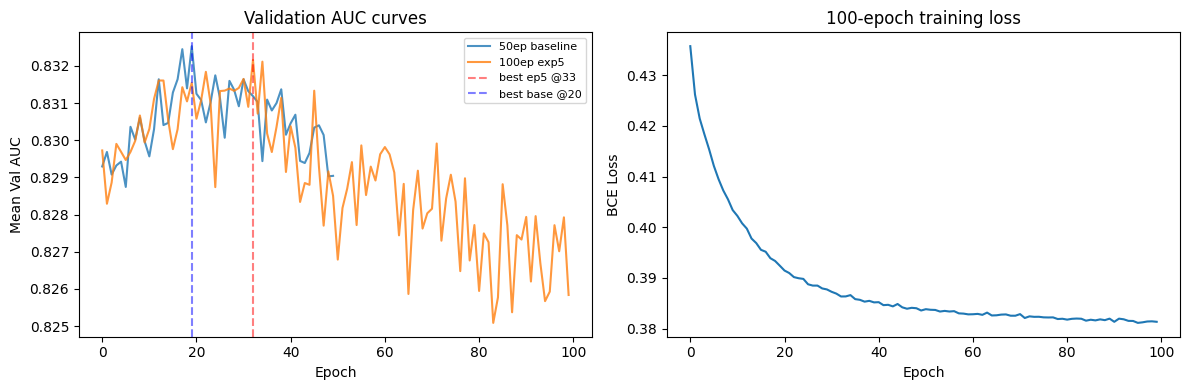


=== Experiment 5: 100-epoch + best checkpoint ===
Best epoch restored: 33
Mean NIH AUC:  0.7357  (baseline: 0.7410)
DRE ESS%:      23.8%  (baseline: 21.2%)
Deferral rate: 0.150
Mean FNR:      0.2020  (baseline: 0.1607)
Mean PPR:      0.5782
Lambda hats:   {'Atelectasis': np.float64(0.101), 'Cardiomegaly': np.float64(0.046), 'Consolidation': np.float64(0.019), 'Edema': np.float64(0.041), 'Effusion': np.float64(0.032), 'Pneumonia': np.float64(0.012), 'Pneumothorax': np.float64(0.029)}


In [11]:
print("=== Experiment 5: 100-epoch training + best checkpoint ===")
print("Training GNN (100 epochs, save_best=True)...")

gnn_e5, hist_e5 = train_gnn(
    features_train=Xtr_s,
    labels_train=Y_train,
    features_val=Xcal_s,
    labels_val=Y_cal,
    adjacency=A,
    init_logits_train=init_logits_train,
    init_logits_val=init_logits_cal,
    epochs=100,
    save_best=True,
    batch_size=512,
    lr=1e-3,
    weight_decay=1e-4,
    device=DEVICE,
    verbose=False,
)
best_ep_e5 = hist_e5['best_epoch'][0]
print(f"Best epoch: {best_ep_e5}/100  val_auc={max(hist_e5['val_auc']):.4f}  "
      f"(baseline best: epoch {hist_base['best_epoch'][0]}/50  val_auc={max(hist_base['val_auc']):.4f})")

probs_train_gnn_e5 = gnn_predict_probs(gnn_e5, Xtr_s,   init_logits_train)
probs_cal_gnn_e5   = gnn_predict_probs(gnn_e5, Xcal_s,  init_logits_cal)
probs_nih_gnn_e5   = gnn_predict_probs(gnn_e5, Xnih_s,  init_logits_nih)
probs_pool_gnn_e5  = gnn_predict_probs(gnn_e5, Xpool_s, init_logits_pool)

dre_e5 = AdaptiveDRE(n_components=None, weight_clip=None, random_state=SEED)
dre_e5.fit(probs_train_gnn_e5, probs_pool_gnn_e5)
w_cal_e5 = dre_e5.compute_weights(probs_cal_gnn_e5)
diag_e5  = dre_e5.diagnostics(probs_cal_gnn_e5)

scrc_e5 = PerPathologySCRCPredictor(beta=BETA, alpha=ALPHA, seed=SEED)
crc_e5  = scrc_e5.calibrate(
    probs_cal_gnn_e5, Y_cal, w_cal_e5, pathology_names=COMMON_PATHOLOGIES
)
result_e5 = scrc_e5.predict(probs_nih_gnn_e5)
m_e5 = compute_empirical_metrics(result_e5.prediction_sets, result_e5.defer_mask, Y_nih_test)
auc_gnn_e5 = nih_auc_per_pathology(probs_nih_gnn_e5)

# Training curve plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(hist_base["val_auc"], label="50ep baseline", alpha=0.8)
ax1.plot(hist_e5["val_auc"], label="100ep exp5", alpha=0.8)
ax1.axvline(best_ep_e5 - 1, color="red", linestyle="--", alpha=0.5, label=f"best ep5 @{best_ep_e5}")
ax1.axvline(hist_base["best_epoch"][0] - 1, color="blue", linestyle="--", alpha=0.5,
            label=f"best base @{hist_base['best_epoch'][0]}")
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Mean Val AUC"); ax1.set_title("Validation AUC curves")
ax1.legend(fontsize=8)

ax2.plot(hist_e5["train_loss"])
ax2.set_xlabel("Epoch"); ax2.set_ylabel("BCE Loss"); ax2.set_title("100-epoch training loss")
plt.tight_layout()
plt.show()

print(f"\n=== Experiment 5: 100-epoch + best checkpoint ===")
print(f"Best epoch restored: {best_ep_e5}")
print(f"Mean NIH AUC:  {np.nanmean(auc_gnn_e5):.4f}  (baseline: {np.nanmean(auc_gnn_base):.4f})")
print(f"DRE ESS%:      {diag_e5.ess_fraction*100:.1f}%  (baseline: {diag_base.ess_fraction*100:.1f}%)")
print(f"Deferral rate: {result_e5.deferral_rate:.3f}")
print(f"Mean FNR:      {m_e5['empirical_FNR'].dropna().mean():.4f}  (baseline: {m_base['empirical_FNR'].dropna().mean():.4f})")
print(f"Mean PPR:      {m_e5['PPR'].dropna().mean():.4f}")
print(f"Lambda hats:   {dict(zip(COMMON_PATHOLOGIES, crc_e5.lambda_hats.round(3)))}")

## Combined: Exp3 (Cap-alpha) + Exp4 (Cal-src DRE)

Both Exp3 and Exp4 are orthogonal improvements: one changes the α allocation
(how much FNR budget each pathology gets), the other changes the DRE source
(which CheXpert samples are used to estimate importance weights).
Here we apply them simultaneously:

In [12]:
print("=== Combined: Exp3 (Cap-alpha) + Exp4 (Cal-src DRE) ===")
print(f"  alpha_k from Exp3: {dict(zip(COMMON_PATHOLOGIES, alpha_k.round(4)))}")
print(f"  DRE source: cal set ({len(probs_cal_gnn)} samples)  ESS%={diag_e4.ess_fraction*100:.1f}%")

scrc_comb = PerPathologySCRCPredictor(beta=BETA, alpha=alpha_k, seed=SEED)
crc_comb  = scrc_comb.calibrate(
    probs_cal_gnn, Y_cal, w_cal_e4, pathology_names=COMMON_PATHOLOGIES
)
result_comb = scrc_comb.predict(probs_nih_gnn)
m_comb = compute_empirical_metrics(result_comb.prediction_sets, result_comb.defer_mask, Y_nih_test)

print(f"\n=== Combined Exp3+Exp4 ===")
print(f"Mean NIH AUC:  {np.nanmean(auc_gnn_base):.4f}  (same GNN as baseline)")
print(f"DRE ESS%:      {diag_e4.ess_fraction*100:.1f}%  (baseline: {diag_base.ess_fraction*100:.1f}%)")
print(f"Deferral rate: {result_comb.deferral_rate:.3f}")
print(f"Mean FNR:      {m_comb['empirical_FNR'].dropna().mean():.4f}  "
      f"(Exp3: {m_e3['empirical_FNR'].dropna().mean():.4f}  "
      f"Exp4: {m_e4['empirical_FNR'].dropna().mean():.4f}  "
      f"baseline: {m_base['empirical_FNR'].dropna().mean():.4f})")
print(f"Mean PPR:      {m_comb['PPR'].dropna().mean():.4f}")
print(f"Lambda hats:   {dict(zip(COMMON_PATHOLOGIES, crc_comb.lambda_hats.round(3)))}")
print(f"\nPer-pathology FNR — baseline / Exp3 / Exp4 / Combined:")
for k, path in enumerate(COMMON_PATHOLOGIES):
    print(f"  {path:<16}  "
          f"base={m_base['empirical_FNR'].iloc[k]:.4f}  "
          f"e3={m_e3['empirical_FNR'].iloc[k]:.4f}  "
          f"e4={m_e4['empirical_FNR'].iloc[k]:.4f}  "
          f"comb={m_comb['empirical_FNR'].iloc[k]:.4f}")

=== Combined: Exp3 (Cap-alpha) + Exp4 (Cal-src DRE) ===
  alpha_k from Exp3: {'Atelectasis': np.float64(0.1054), 'Cardiomegaly': np.float64(0.0813), 'Consolidation': np.float64(0.0886), 'Edema': np.float64(0.0664), 'Effusion': np.float64(0.0659), 'Pneumonia': np.float64(0.1218), 'Pneumothorax': np.float64(0.1707)}
  DRE source: cal set (12906 samples)  ESS%=30.9%

=== Combined Exp3+Exp4 ===
Mean NIH AUC:  0.7410  (same GNN as baseline)
DRE ESS%:      30.9%  (baseline: 21.2%)
Deferral rate: 0.150
Mean FNR:      0.1663  (Exp3: 0.1507  Exp4: 0.1600  baseline: 0.1607)
Mean PPR:      0.6443
Lambda hats:   {'Atelectasis': np.float64(0.111), 'Cardiomegaly': np.float64(0.037), 'Consolidation': np.float64(0.028), 'Edema': np.float64(0.035), 'Effusion': np.float64(0.028), 'Pneumonia': np.float64(0.025), 'Pneumothorax': np.float64(0.065)}

Per-pathology FNR — baseline / Exp3 / Exp4 / Combined:
  Atelectasis       base=0.1721  e3=0.1773  e4=0.1670  comb=0.1721
  Cardiomegaly      base=0.1418  e3=0

## MLP Baseline: Matched-Parameter Comparison

Two-layer MLP with H=1316 hidden units (~1.36M params, matching LabelGCN).
Trained identically (50 ep, Adam lr=1e-3, save_best=True). No graph structure, no init_logits residual.
Evaluated with: (a) uniform α=0.10 and (b) capability-aware alpha (same formula as Exp3).

In [13]:
import copy
import torch.nn as nn

# ---- MLP architecture ----
# param count: 1024*1316 + 1316 + 1316*7 + 7 = 1,358,119  (matches LabelGCN 1,357,883)
class MLP(nn.Module):
    def __init__(self, feat_dim=1024, hidden_dim=1316, K=7, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, K),
        )

    def forward(self, x):
        return self.net(x)   # raw logits [N, K]


def train_mlp(
    features_train, labels_train,
    features_val,   labels_val,
    feat_dim=1024, hidden_dim=1316, K=7, dropout=0.3,
    epochs=50, batch_size=512,
    lr=1e-3, weight_decay=1e-4,
    device="cpu", seed=42, verbose=False,
    save_best=True,
):
    """Train a two-layer MLP with NaN-masked BCE loss. Mirrors train_gnn API."""
    torch.manual_seed(seed)
    model = MLP(feat_dim=feat_dim, hidden_dim=hidden_dim, K=K, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    bce = nn.BCEWithLogitsLoss(reduction="none")

    Xtr = torch.tensor(features_train, dtype=torch.float32).to(device)
    Ytr = torch.tensor(np.where(np.isnan(labels_train), -1.0, labels_train),
                       dtype=torch.float32).to(device)
    Xval = torch.tensor(features_val, dtype=torch.float32).to(device)
    Yval_np = labels_val   # keep as numpy for roc_auc_score

    N = Xtr.shape[0]
    history = {"train_loss": [], "val_auc": [], "best_epoch": []}
    best_val_auc = -1.0
    best_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        perm = torch.randperm(N, device=device)
        epoch_loss = 0.0
        n_batches = 0
        for start in range(0, N, batch_size):
            idx = perm[start:start + batch_size]
            xb, yb = Xtr[idx], Ytr[idx]
            logits = model(xb)
            valid_mask = (yb >= 0).float()
            yb_safe = yb.clamp(min=0)
            loss_raw = bce(logits, yb_safe)
            valid_count = valid_mask.sum().clamp(min=1)
            loss = (loss_raw * valid_mask).sum() / valid_count
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            n_batches += 1
        history["train_loss"].append(epoch_loss / n_batches)

        # Validation AUC (NaN-masked)
        model.eval()
        with torch.no_grad():
            val_logits = model(Xval).cpu().numpy()
        val_probs = 1.0 / (1.0 + np.exp(-val_logits))   # sigmoid
        aucs = []
        for k in range(K):
            valid = ~np.isnan(Yval_np[:, k])
            if valid.sum() < 10 or len(np.unique(Yval_np[valid, k])) < 2:
                continue
            aucs.append(roc_auc_score(Yval_np[valid, k], val_probs[valid, k]))
        mean_auc = float(np.mean(aucs)) if aucs else 0.0
        history["val_auc"].append(mean_auc)

        if save_best and mean_auc > best_val_auc:
            best_val_auc = mean_auc
            best_state = copy.deepcopy(model.state_dict())
            history["best_epoch"] = [epoch]

        if verbose:
            print(f"  Epoch {epoch:3d}/{epochs}  loss={epoch_loss/n_batches:.4f}  val_auc={mean_auc:.4f}")

    if save_best and best_state is not None:
        model.load_state_dict(best_state)
    return model.cpu(), history


# ---- Verify parameter count ----
_mlp_tmp = MLP()
_n_params = sum(p.numel() for p in _mlp_tmp.parameters())
print(f"MLP param count: {_n_params:,}  (LabelGCN: 1,357,883)")
del _mlp_tmp

# ---- Train MLP ----
print("Training MLP (50 epochs, save_best=True)...")
mlp_base, hist_mlp = train_mlp(
    features_train=Xtr_s,
    labels_train=Y_train,
    features_val=Xcal_s,
    labels_val=Y_cal,
    epochs=50,
    save_best=True,
    batch_size=512,
    lr=1e-3,
    weight_decay=1e-4,
    device=DEVICE,
    seed=SEED,
    verbose=False,
)
print(f"Best val AUC: {max(hist_mlp['val_auc']):.4f}  at epoch {hist_mlp['best_epoch'][0]}")

# ---- MLP probabilities ----
def mlp_predict_probs(model, features_np):
    model.eval()
    X_t = torch.tensor(features_np, dtype=torch.float32)
    with torch.no_grad():
        logits = model(X_t).numpy()
    return 1.0 / (1.0 + np.exp(-logits))

probs_train_mlp = mlp_predict_probs(mlp_base, Xtr_s)
probs_cal_mlp   = mlp_predict_probs(mlp_base, Xcal_s)
probs_nih_mlp   = mlp_predict_probs(mlp_base, Xnih_s)
probs_pool_mlp  = mlp_predict_probs(mlp_base, Xpool_s)
print(f"probs_nih_mlp shape: {probs_nih_mlp.shape}  range: [{probs_nih_mlp.min():.4f}, {probs_nih_mlp.max():.4f}]")

# ---- NIH AUC ----
auc_mlp = nih_auc_per_pathology(probs_nih_mlp)
print(f"\nMLP NIH AUC per pathology:")
for path, auc in zip(COMMON_PATHOLOGIES, auc_mlp):
    print(f"  {path:<16}  {auc:.4f}")
print(f"Mean NIH AUC: {np.nanmean(auc_mlp):.4f}  (GNN baseline: {np.nanmean(auc_gnn_base):.4f})")

# ---- DRE-C on 7-dim MLP probs (train-as-source) ----
dre_mlp = AdaptiveDRE(n_components=None, weight_clip=None, random_state=SEED)
dre_mlp.fit(probs_train_mlp, probs_pool_mlp)
w_cal_mlp = dre_mlp.compute_weights(probs_cal_mlp)
diag_mlp  = dre_mlp.diagnostics(probs_cal_mlp)
print(f"\nMLP DRE-C: domain_auc={diag_mlp.domain_auc:.4f}  "
      f"ESS={diag_mlp.ess:.1f}  ESS%={diag_mlp.ess_fraction*100:.1f}%")
print(f"Baseline GNN DRE-C: domain_auc={diag_base.domain_auc:.4f}  ESS%={diag_base.ess_fraction*100:.1f}%")

# ---- (a) Uniform alpha ----
scrc_mlp = PerPathologySCRCPredictor(beta=BETA, alpha=ALPHA, seed=SEED)
crc_mlp  = scrc_mlp.calibrate(probs_cal_mlp, Y_cal, w_cal_mlp, pathology_names=COMMON_PATHOLOGIES)
result_mlp = scrc_mlp.predict(probs_nih_mlp)
m_mlp = compute_empirical_metrics(result_mlp.prediction_sets, result_mlp.defer_mask, Y_nih_test)

# ---- (b) Capability-aware alpha (same formula as Exp3) ----
alpha_k_mlp = compute_capability_alpha(
    nih_aucs=auc_mlp,
    alpha_global=ALPHA,
    pathology_names=COMMON_PATHOLOGIES,
)
scrc_mlp_cap = PerPathologySCRCPredictor(beta=BETA, alpha=alpha_k_mlp, seed=SEED)
crc_mlp_cap  = scrc_mlp_cap.calibrate(probs_cal_mlp, Y_cal, w_cal_mlp, pathology_names=COMMON_PATHOLOGIES)
result_mlp_cap = scrc_mlp_cap.predict(probs_nih_mlp)
m_mlp_cap = compute_empirical_metrics(result_mlp_cap.prediction_sets, result_mlp_cap.defer_mask, Y_nih_test)

print(f"\n=== MLP Baseline Results ===")
print(f"{'':20s}  {'AUC':>6}  {'ESS%':>6}  {'Defer':>6}  {'FNR':>6}  {'PPR':>6}")
print(f"{'MLP (uniform α)':20s}  {np.nanmean(auc_mlp):.4f}  "
      f"{diag_mlp.ess_fraction*100:5.1f}%  {result_mlp.deferral_rate:.3f}  "
      f"{m_mlp['empirical_FNR'].dropna().mean():.4f}  {m_mlp['PPR'].dropna().mean():.4f}")
print(f"{'MLP (cap-alpha)':20s}  {np.nanmean(auc_mlp):.4f}  "
      f"{diag_mlp.ess_fraction*100:5.1f}%  {result_mlp_cap.deferral_rate:.3f}  "
      f"{m_mlp_cap['empirical_FNR'].dropna().mean():.4f}  {m_mlp_cap['PPR'].dropna().mean():.4f}")
print(f"{'GNN (uniform α)':20s}  {np.nanmean(auc_gnn_base):.4f}  "
      f"{diag_base.ess_fraction*100:5.1f}%  {result_base.deferral_rate:.3f}  "
      f"{m_base['empirical_FNR'].dropna().mean():.4f}  {m_base['PPR'].dropna().mean():.4f}")
print(f"{'GNN (cap-alpha)':20s}  {np.nanmean(auc_gnn_base):.4f}  "
      f"{diag_base.ess_fraction*100:5.1f}%  {result_e3.deferral_rate:.3f}  "
      f"{m_e3['empirical_FNR'].dropna().mean():.4f}  {m_e3['PPR'].dropna().mean():.4f}")

print(f"\nPer-pathology FNR — MLP(unif) / MLP(cap) / GNN(unif) / GNN(cap):")
for k, path in enumerate(COMMON_PATHOLOGIES):
    print(f"  {path:<16}  "
          f"mlp_u={m_mlp['empirical_FNR'].iloc[k]:.4f}  "
          f"mlp_c={m_mlp_cap['empirical_FNR'].iloc[k]:.4f}  "
          f"gnn_u={m_base['empirical_FNR'].iloc[k]:.4f}  "
          f"gnn_c={m_e3['empirical_FNR'].iloc[k]:.4f}")

MLP param count: 1,358,119  (LabelGCN: 1,357,883)
Training MLP (50 epochs, save_best=True)...


Best val AUC: 0.8298  at epoch 3
probs_nih_mlp shape: (15403, 7)  range: [0.0000, 0.9970]

MLP NIH AUC per pathology:
  Atelectasis       0.6987
  Cardiomegaly      0.7711
  Consolidation     0.7251
  Edema             0.8056
  Effusion          0.8139
  Pneumonia         0.6560
  Pneumothorax      0.4714
Mean NIH AUC: 0.7060  (GNN baseline: 0.7410)



MLP DRE-C: domain_auc=0.8313  ESS=4628.4  ESS%=35.9%
Baseline GNN DRE-C: domain_auc=0.8505  ESS%=21.2%

=== MLP Baseline Results ===
                         AUC    ESS%   Defer     FNR     PPR
MLP (uniform α)       0.7060   35.9%  0.150  0.1815  0.6402
MLP (cap-alpha)       0.7060   35.9%  0.150  0.1230  0.8557
GNN (uniform α)       0.7410   21.2%  0.150  0.1607  0.6281
GNN (cap-alpha)       0.7410   21.2%  0.150  0.1507  0.6494

Per-pathology FNR — MLP(unif) / MLP(cap) / GNN(unif) / GNN(cap):
  Atelectasis       mlp_u=0.1597  mlp_c=0.0000  gnn_u=0.1721  gnn_c=0.1773
  Cardiomegaly      mlp_u=0.1051  mlp_c=0.0000  gnn_u=0.1418  gnn_c=0.1007
  Consolidation     mlp_u=0.1969  mlp_c=0.0157  gnn_u=0.2149  gnn_c=0.1901
  Edema             mlp_u=0.1905  mlp_c=0.0000  gnn_u=0.1579  gnn_c=0.0526
  Effusion          mlp_u=0.1078  mlp_c=0.0000  gnn_u=0.0806  gnn_c=0.0387
  Pneumonia         mlp_u=0.0877  mlp_c=0.0000  gnn_u=0.1224  gnn_c=0.1429
  Pneumothorax      mlp_u=0.4227  mlp_c=0.8454  g

## Summary: All Experiments vs Baseline

In [14]:
# ---- Build summary DataFrame ----
rows = []

for label, auc_arr, diag, result, m in [
    ("Baseline (Method C)",  auc_gnn_base, diag_base, result_base,  m_base),
    ("Exp1: GNN+PCA64",      auc_gnn_e1,   diag_e1,   result_e1,    m_e1),
    ("Exp2: Post-sel DRE",   auc_gnn_base, diag_e2,   None,         m_e2),
    ("Exp3: Cap-alpha",      auc_gnn_base, diag_base, result_e3,    m_e3),
    ("Exp4: Cal-src DRE",    auc_gnn_base, diag_e4,   result_e4,    m_e4),
    ("Exp5: 100ep+best",     auc_gnn_e5,   diag_e5,   result_e5,    m_e5),
    ("Exp3+4: Combined",     auc_gnn_base, diag_e4,   result_comb,  m_comb),
    ("MLP (uniform α)",      auc_mlp,      diag_mlp,  result_mlp,   m_mlp),
    ("MLP (cap-alpha)",      auc_mlp,      diag_mlp,  result_mlp_cap, m_mlp_cap),
]:
    if result is not None:
        defer_rate = result.deferral_rate
    else:
        defer_rate = defer_nih_e2.mean()

    rows.append({
        "Method":    label,
        "Mean AUC":  round(float(np.nanmean(auc_arr)), 4),
        "DRE ESS%":  round(float(diag.ess_fraction * 100), 1),
        "Deferral":  round(defer_rate, 3),
        "Mean FNR":  round(float(m["empirical_FNR"].dropna().mean()), 4),
        "Mean PPR":  round(float(m["PPR"].dropna().mean()), 4),
    })

summary_df = pd.DataFrame(rows).set_index("Method")
print("=== Full Experiment Comparison (β=0.15, α=0.10) ===")
print(summary_df.to_string())

best_fnr_method = summary_df["Mean FNR"].idxmin()
best_auc_method = summary_df["Mean AUC"].idxmax()
best_ess_method = summary_df["DRE ESS%"].idxmax()
print(f"\nBest Mean FNR:  {best_fnr_method}  ({summary_df.loc[best_fnr_method, 'Mean FNR']:.4f})")
print(f"Best Mean AUC:  {best_auc_method}  ({summary_df.loc[best_auc_method, 'Mean AUC']:.4f})")
print(f"Best DRE ESS%:  {best_ess_method}  ({summary_df.loc[best_ess_method, 'DRE ESS%']:.1f}%)")

print("\n=== Per-pathology FNR breakdown ===")
fnr_detail = pd.DataFrame({
    "Baseline":     m_base["empirical_FNR"],
    "Exp3 CapAlp":  m_e3["empirical_FNR"],
    "Exp4 CalSrc":  m_e4["empirical_FNR"],
    "Exp3+4 Comb":  m_comb["empirical_FNR"],
    "MLP Unif":     m_mlp["empirical_FNR"],
    "MLP CapAlp":   m_mlp_cap["empirical_FNR"],
})
print(fnr_detail.round(4).to_string())

=== Full Experiment Comparison (β=0.15, α=0.10) ===
                     Mean AUC  DRE ESS%  Deferral  Mean FNR  Mean PPR
Method                                                               
Baseline (Method C)    0.7410      21.2      0.15    0.1607    0.6281
Exp1: GNN+PCA64        0.7370      29.8      0.15    0.1651    0.5954
Exp2: Post-sel DRE     0.7410      34.1      0.15    0.1810    0.5860
Exp3: Cap-alpha        0.7410      21.2      0.15    0.1507    0.6494
Exp4: Cal-src DRE      0.7410      30.9      0.15    0.1600    0.6308
Exp5: 100ep+best       0.7357      23.8      0.15    0.2020    0.5782
Exp3+4: Combined       0.7410      30.9      0.15    0.1663    0.6443
MLP (uniform α)        0.7060      35.9      0.15    0.1815    0.6402
MLP (cap-alpha)        0.7060      35.9      0.15    0.1230    0.8557

Best Mean FNR:  MLP (cap-alpha)  (0.1230)
Best Mean AUC:  Baseline (Method C)  (0.7410)
Best DRE ESS%:  MLP (uniform α)  (35.9%)

=== Per-pathology FNR breakdown ===
           

In [15]:
# ---- Per-pathology FPR for GNN cap-alpha (Exp3) and MLP cap-alpha ----
def compute_fpr_per_pathology(prediction_sets, defer_mask, y_nih):
    kept = ~defer_mask
    rows = []
    for k, path in enumerate(COMMON_PATHOLOGIES):
        valid_kept = (~np.isnan(y_nih[:, k])) & kept
        if valid_kept.sum() == 0:
            rows.append({"Pathology": path, "FPR": float("nan")})
            continue
        y_k    = y_nih[valid_kept, k]
        pred_k = prediction_sets[valid_kept, k]
        fp  = ((pred_k == 1) & (y_k == 0)).sum()
        tn  = ((pred_k == 0) & (y_k == 0)).sum()
        fpr = fp / max(1, fp + tn)
        rows.append({"Pathology": path, "FPR": round(fpr, 4)})
    return pd.DataFrame(rows).set_index("Pathology")

fpr_gnn_cap = compute_fpr_per_pathology(
    result_e3.prediction_sets, result_e3.defer_mask, Y_nih_test)
fpr_mlp_cap = compute_fpr_per_pathology(
    result_mlp_cap.prediction_sets, result_mlp_cap.defer_mask, Y_nih_test)

print("=== Per-pathology FPR (cap-alpha, beta=0.15, alpha=0.10) ===")
fpr_df = pd.DataFrame({
    "GNN (cap-alpha)": fpr_gnn_cap["FPR"],
    "MLP (cap-alpha)": fpr_mlp_cap["FPR"],
})
print(fpr_df.round(4).to_string())
mean_gnn = fpr_gnn_cap['FPR'].dropna().mean()
mean_mlp = fpr_mlp_cap['FPR'].dropna().mean()
print(f"\nMean FPR  GNN: {mean_gnn:.4f}   MLP: {mean_mlp:.4f}")


=== Per-pathology FPR (cap-alpha, beta=0.15, alpha=0.10) ===
               GNN (cap-alpha)  MLP (cap-alpha)
Pathology                                      
Atelectasis             0.5770           0.9914
Cardiomegaly            0.5512           0.9917
Consolidation           0.5883           0.9319
Edema                   0.6914           0.9565
Effusion                0.8226           0.9981
Pneumonia               0.7747           0.9810
Pneumothorax            0.5156           0.1379

Mean FPR  GNN: 0.6458   MLP: 0.8555
